# Service optimization

In [1]:
import geopandas as gpd

blocks = gpd.read_parquet('./../../data/blocks.parquet')
columns = [c for c in blocks.columns if 'capacity_' in c]
blocks = blocks[['geometry', 'population', 'site_area', *columns]].copy()
blocks.head(3)

,geometry,population,site_area,capacity_convenience,capacity_cafe,capacity_mall,capacity_pharmacy,capacity_bank,capacity_fuel,capacity_pitch,...,capacity_bus_station,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse,capacity_machine_building_plant
id,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",565.0,804466.712114,208.0,0.0,2216.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",42.0,23173.129862,811.0,25.0,0.0,0.0,148.0,0.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",19.0,363005.815802,0.0,0.0,0.0,0.0,0.0,501.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import pandas as pd

accessibility_matrix = pd.read_pickle('./../../data/accessibility_matrix.pickle')
accessibility_matrix.head()

/home/ivan/work/ovanes-projects/urban-planning-optimizer/general/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,16310,16311,16312,16313,16314,16315,16316,16317,16318,16319
0,0.000000,18.718750,9.234375,17.21875,30.296875,27.390625,30.671875,23.281250,78.6875,81.2500,...,76.5625,102.5625,97.5000,132.250,130.8750,142.125,247.625,228.625,247.625,124.6250
1,17.859375,0.000000,19.015625,7.65625,20.281250,25.250000,25.234375,15.765625,76.8750,79.4375,...,74.6875,100.7500,95.6875,130.500,129.0000,140.250,245.875,226.875,245.875,112.5000
2,9.234375,20.796875,0.000000,20.21875,27.968750,25.062500,28.343750,20.953125,71.8750,74.4375,...,69.7500,95.8125,90.6875,125.500,124.0625,135.375,240.875,221.875,240.875,124.6250
3,15.937500,7.449219,18.421875,0.00000,21.109375,24.984375,27.781250,16.593750,76.3125,78.8125,...,74.1250,100.1875,95.0625,129.875,128.5000,139.750,245.250,226.250,245.250,113.3750
4,31.906250,19.765625,31.734375,21.28125,0.000000,21.781250,23.125000,15.429688,89.5625,92.1250,...,87.4375,113.5000,108.3750,143.125,141.7500,153.000,258.500,239.500,258.500,108.3125


### Select ID of optimized blocks

In [3]:
from blocksnet.enums import LandUse
blocks_lu = {
    1536 : LandUse.BUSINESS
}

### Service distribution

In [4]:
basic_services = {
    "kindergarten": 0.2,
    "school": 0.2,
    "pharmacy": 0.2,
    "polyclinics": 0.3,
    "convenience": 0.2,   
    "cafe": 0.15,
    "playground": 0.2,
    "post": 0.1,
    "hairdresser": 0.1
}
advanced_services = {
    "hospital": 0.5,
    "supermarket": 0.4,
    "restaurant": 0.3,
    "park": 0.8,
    "bank": 0.3,
    "fuel": 0.25,
    "police": 0.2,
    "cinema": 0.2,
    "market": 0.2,
    "religion": 0.5,
    "multifunctional_center": 0.1
}
comfort_services = {
    "mall": 0.3,   
    "swimming_pool": 0.4,
    "theatre": 0.2,
    "museum": 0.2,
    "university": 0.2,
    "sanatorium": 0.2,
}


def get_service_weight(service_name):
    if service_name in basic_services:
        return 0.5714 * basic_services[service_name] / sum(basic_services.values())
    elif service_name in advanced_services:
        return 0.2857 * advanced_services[service_name] / sum(advanced_services.values())
    elif service_name in comfort_services:
        return 0.1429 * comfort_services[service_name] / sum(comfort_services.values())
    return 0

### Service types and weights

In [5]:
chosen_service_types = set(basic_services) | set(advanced_services) | set(comfort_services)
service_weights = {service_type: get_service_weight(service_type) for service_type in chosen_service_types if f'capacity_{service_type}' in blocks.columns}

### Initialize and run optimizer

In [6]:
import csv
import numpy as np
def save_provisions_capacity(facade, var_adapter):
    start_prov = facade.start_provisions

    max_capacities = facade.get_max_capacities(1536)

    with open('./results/capacity_provisions_data.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Service type", "Capacity required", "Total capacity of units", "Demand left (start)", "Demand left (after opt.)", "Opt. provisions", "Start provisions"])  # Write header row
        for st, max_cap in max_capacities.items():
            vars = var_adapter(np.zeros(facade.num_params))
            tot_cap = 0
            max_cap *= 1.2
            for var in vars:
                if var.service_type == st:
                    var.count = int(np.ceil(max_cap / var.capacity))
                    tot_cap = var.total_capacity
                    break
            vars_df = var_adapter._variables_to_df(vars)

            demand = facade._provision_adapter.get_start_provision_df(st)["demand_left"].sum()

            prov = facade._provision_adapter.calculate_provision(st, vars_df)

            demand_opt = facade._provision_adapter.get_last_provision_df(st)["demand_left"].sum()

            writer.writerow([st, max_cap, tot_cap, demand, demand_opt, prov, start_prov[st]])

In [ ]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    AreaSolution,
    GradientChooser,
    SimpleChooser,
)
from tqdm import tqdm

var_adapter = AreaSolution(blocks_lu)

facade = Facade(
    blocks_lu=blocks_lu,
    blocks_df=blocks,
    accessibility_matrix=accessibility_matrix,
    var_adapter=var_adapter,
)

for service_type, weight in tqdm(service_weights.items()):
    facade.add_service_type(service_type, weight, blocks.rename(columns={f'capacity_{service_type}': 'capacity'})[['capacity']])

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=service_weights, max_evals=50)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=SimpleChooser(facade)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=1000, timeout=60000, initial_runs_num=1)

/home/ivan/work/ovanes-projects/urban-planning-optimizer/general/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 25/25 [08:01<00:00, 19.25s/it]
[I 2025-05-14 03:13:57,555] A new study created in memory with name: no-name-f9dcc2ce-7fa4-4930-9aa3-940270186cd2
Best trial: 0. Best value: 0.633296:   0%|          | 1/1000 [00:00<14:39,  1.14it/s, 0.88/60000 seconds]

[I 2025-05-14 03:13:58,435] Trial 0 finished with value: 0.6332961339703179 and parameters: {'x_0': 6708, 'x_3': 140, 'x_4': 2579, 'x_5': 1428, 'x_7': 4985, 'x_8': 22124, 'x_9': 22124}. Best is trial 0 with value: 0.6332961339703179.


Best trial: 0. Best value: 0.633296:   0%|          | 2/1000 [00:01<15:23,  1.08it/s, 1.84/60000 seconds]

[I 2025-05-14 03:13:59,392] Trial 1 finished with value: 0.6332961339703179 and parameters: {'x_0': 6400, 'x_3': 0, 'x_4': 2400, 'x_5': 0, 'x_7': 4800, 'x_8': 18000, 'x_9': 18000}. Best is trial 0 with value: 0.6332961339703179.


Best trial: 2. Best value: 0.643604:   0%|          | 3/1000 [00:02<16:31,  1.01it/s, 2.91/60000 seconds]

[I 2025-05-14 03:14:00,468] Trial 2 finished with value: 0.6436043207761173 and parameters: {'x_0': 18822, 'x_4': 6006, 'x_7': 12521, 'x_8': 52411, 'x_9': 41856}. Best is trial 2 with value: 0.6436043207761173.


Best trial: 2. Best value: 0.643604:   0%|          | 4/1000 [00:03<16:01,  1.04it/s, 3.83/60000 seconds]

[I 2025-05-14 03:14:01,388] Trial 3 finished with value: 0.6436043207761173 and parameters: {'x_0': 18700, 'x_4': 6000, 'x_7': 12000, 'x_8': 50500, 'x_9': 36000}. Best is trial 2 with value: 0.6436043207761173.


Best trial: 4. Best value: 0.663949:   0%|          | 5/1000 [00:04<16:05,  1.03it/s, 4.81/60000 seconds]

[I 2025-05-14 03:14:02,369] Trial 4 finished with value: 0.663949326963307 and parameters: {'x_0': 52849, 'x_4': 12023, 'x_7': 28847, 'x_8': 61316, 'x_9': 66032}. Best is trial 4 with value: 0.663949326963307.


Best trial: 4. Best value: 0.663949:   1%|          | 6/1000 [00:06<17:24,  1.05s/it, 6.02/60000 seconds]

[I 2025-05-14 03:14:03,573] Trial 5 finished with value: 0.663949326963307 and parameters: {'x_0': 49700, 'x_4': 12000, 'x_7': 28800, 'x_8': 50500, 'x_9': 63000}. Best is trial 4 with value: 0.663949326963307.


Best trial: 6. Best value: 0.667146:   1%|          | 7/1000 [00:06<16:35,  1.00s/it, 6.92/60000 seconds]

[I 2025-05-14 03:14:04,479] Trial 6 finished with value: 0.6671458191167801 and parameters: {'x_0': 67069, 'x_4': 8467, 'x_7': 34337, 'x_9': 99788}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|          | 8/1000 [00:07<15:55,  1.04it/s, 7.80/60000 seconds]

[I 2025-05-14 03:14:05,359] Trial 7 finished with value: 0.6671458191167801 and parameters: {'x_0': 65200, 'x_4': 8400, 'x_7': 34300, 'x_9': 99000}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|          | 9/1000 [00:08<15:12,  1.09it/s, 8.63/60000 seconds]

[I 2025-05-14 03:14:06,187] Trial 8 finished with value: 0.6613813108665557 and parameters: {'x_0': 38313, 'x_4': 15576, 'x_7': 21598, 'x_8': 145203, 'x_9': 4}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|          | 10/1000 [00:09<13:10,  1.25it/s, 9.16/60000 seconds]

[I 2025-05-14 03:14:06,710] Trial 9 finished with value: 0.6594970714681336 and parameters: {'x_0': 37400, 'x_4': 15560, 'x_7': 21400, 'x_8': 130000, 'x_9': 0}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|          | 11/1000 [00:10<13:53,  1.19it/s, 10.10/60000 seconds]

[I 2025-05-14 03:14:07,653] Trial 10 finished with value: 0.6561128916994519 and parameters: {'x_0': 66568, 'x_4': 45, 'x_7': 39504, 'x_9': 113436}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|          | 12/1000 [00:10<14:00,  1.18it/s, 10.97/60000 seconds]

[I 2025-05-14 03:14:08,522] Trial 11 finished with value: 0.6561128916994519 and parameters: {'x_0': 65200, 'x_4': 0, 'x_7': 39400, 'x_9': 108000}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|▏         | 13/1000 [00:11<13:23,  1.23it/s, 11.70/60000 seconds]

[I 2025-05-14 03:14:09,250] Trial 12 finished with value: 0.6630251093526804 and parameters: {'x_0': 54099, 'x_4': 8274, 'x_7': 30560, 'x_8': 405, 'x_9': 90373}. Best is trial 6 with value: 0.6671458191167801.


Best trial: 6. Best value: 0.667146:   1%|▏         | 14/1000 [00:12<14:33,  1.13it/s, 12.40/60000 seconds]

[I 2025-05-14 03:14:09,954] Trial 13 finished with value: 0.6621311750699136 and parameters: {'x_0': 52900, 'x_4': 8160, 'x_7': 30000, 'x_8': 0, 'x_9': 90000}. Best is trial 6 with value: 0.6671458191167801.


Convert to services dataframe

In [ ]:
solution_df = facade.solution_to_services_df(best_x)
solution_df.to_csv(f'tpe_services.csv')
solution_df.head(5)

,block_id,service_type,site_area,build_floor_area,capacity,count
0,1536,swimming_pool,2000.0,1200.0,150,1
3,1536,swimming_pool,10000.0,5500.0,1000,4
20,1536,post,0.0,240.0,60,35
35,1536,multifunctional_center,0.0,700.0,150,1
37,1536,multifunctional_center,0.0,1200.0,500,28


### Visualization

In [ ]:
import matplotlib.pyplot as plt


def plot_df(df):
    df_called_obj = df.loc[df["called_obj"] == True]

    plt.scatter(df_called_obj["func_evals"], df_called_obj["best_val"], c="red", s=5)

    df_called_obj = pd.concat(
        [pd.DataFrame([[-1, None, 0, 0, None, 0, False, 0]], columns=df_called_obj.columns), df_called_obj]
    )
    plt.plot(
        df_called_obj["func_evals"], df_called_obj["best_val"], label="Best Value (TPE)", color="blue", linewidth=1
    )
    # Добавление точек с цветом в зависимости от 'called_obj'
    # Настройка осей и заголовка
    plt.xlabel("Number of objective evaluation")
    plt.ylabel("Best Value")
    plt.title("Best Value Across Trials")
    plt.legend()
    plt.grid(True)

    # Отображение графика
    plt.show()

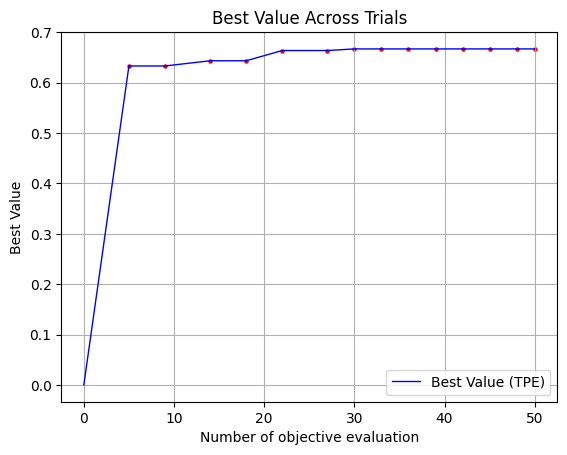

In [ ]:
import pandas as pd

tpe_df = pd.read_csv("tpe_trials.csv")
plot_df(tpe_df)